## <span style="font-family: Arial; font-weight:bold;font-size:1.9em;color:#0e92ea">Assignment 7: Bank Churn Prediction </span>


<p align="center" style="font-family: Arial;color:#0e92ea;font-size:1em;">
Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.
</p>

##  <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#0e92ea">Data Dictionary:</span>

<ol style="font-family: Arial;color:#0e92ea;font-size:1em;">
    <li>CustomerId: Unique ID which is assigned to each customer</li>
    <li>Surname: Last name of the customer</li> 
    <li>CreditScore: It defines the credit history of the customer.</li>  
    <li>Geography: A customer’s location</li>    
    <li>Gender: It defines the Gender of the customer</li>   
    <li>Age: Age of the customer</li>     
    <li>Tenure: Number of years for which the customer has been with the bank</li>
    <li>NumOfProducts: It refers to the number of products that a customer has purchased through the bank.</li>
    <li>Balance: Account balance</li>
    <li>HasCrCard: It is a categorical variable that decides whether the customer has a credit card or not.</li>
    <li>EstimatedSalary: Estimated salary</li> 
    <li>isActiveMember: It is a categorical variable that decides whether the customer is an active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions, etc )
    <li>Exited: It is a categorical variable that decides whether the customer left the bank within six months or not. It can take two values</li>
        <ul>
            <li>0=No ( Customer did not leave the bank )</li>
            <li>1=Yes ( Customer left the bank )</li>
        </ul>
    </li>
</ol>

In [1]:
import keras
import warnings
import pprint
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

warnings.filterwarnings('ignore')
main_data = pd.read_csv('Dataset - bank.csv')

In [2]:
main_data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [3]:
main_data.shape

(10000, 14)

### Drop ID Based Columns

- `RowNumber`: Row number is not likely to repeat itself or any helpful in generalizing the data so we can drop this value.
- `CustomerId`: Same applies to customer Id. It uniquely identifies the customer but does not help us categorise and generalize for unseen data/test data as it does not repeat itself.
- `Surname`: We can argue that people with a specific surname might belong to the same family and are more/less likely to leave but this is just stereotyping. People of the same surname dont all all belong to the same family so this feature can be left out too.

In [4]:
FEATURES_TO_DROP = ['RowNumber', 'CustomerId', 'Surname']
main_data.drop(FEATURES_TO_DROP, axis=1, inplace=True)
main_data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
'''
Input:
Pandas DataFrame

Output:
Displays DataFrame structure 
(columns, nulls and non nulls counts and percentage highlighing columns with most number of nulls)

Retunrs:
N/A
'''
def info(dataFrame):
    print(f"{dataFrame.shape[0]} Rows x {dataFrame.shape[1]} Columns")
    missing_values             = dataFrame.isna().sum()         # Get a series counting number of empty values for each column
    non_missing_values         = dataFrame.notnull().sum()      # Get a series counting number of non empty valuesfor each column 
    missing_values_percentage  = ((missing_values * 100)/(missing_values + non_missing_values)).astype(float)
    column_datatypes           = dataFrame.dtypes               # Get a series containing data types for each column 
    
    features      = [missing_values, missing_values_percentage, column_datatypes]
    feature_names = ["No. Of Missing Values", "Missing Values %", "Data Type"]
    
    df = pd.concat(
        objs = features,
        axis = 1,
        keys = feature_names, 
        sort = True)
    
    cm = sns.light_palette("red", as_cmap=True)
    display(df.style.background_gradient(cmap=cm, subset=pd.IndexSlice[:, feature_names[1]]).format(formatter={(feature_names[1]): "{:.2f}%"})) 

In [6]:
info(main_data)

10000 Rows x 11 Columns


,No. Of Missing Values,Missing Values %,Data Type
Age,0,0.00%,int64
Balance,0,0.00%,float64
CreditScore,0,0.00%,int64
EstimatedSalary,0,0.00%,float64
Exited,0,0.00%,int64
Gender,0,0.00%,object
Geography,0,0.00%,object
HasCrCard,0,0.00%,int64
IsActiveMember,0,0.00%,int64
NumOfProducts,0,0.00%,int64


In [7]:
main_data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Split The Data

In [8]:
# Separating data into X and Y

TARGET_COLUMN = "Exited"

X = main_data.drop([TARGET_COLUMN], axis = 1)
Y = main_data[TARGET_COLUMN]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

print(x_train.shape, x_test.shape)

(8000, 10) (2000, 10)


# Data Transformation and Feature Engineering

### Fix Data Types

In [9]:
'''
Input:
Target type and a list of feature names.

Output:
Convert all features with type 'object' to Target type provided in 'toType'

Returns:
modifies main original data frame and returns nothing.
'''
def TransformDataType(toType = "category", df = np.nan):
    column_names = df.select_dtypes(include=['object']).columns.tolist()
    for col_name in column_names:
        df[col_name] = df[col_name].astype(toType)
    print(f"Data Types Converted for features: {column_names}")
    info(df)        

TransformDataType('category', x_train)
x_train.head(2)

Data Types Converted for features: ['Geography', 'Gender']
8000 Rows x 10 Columns


,No. Of Missing Values,Missing Values %,Data Type
Age,0,0.00%,int64
Balance,0,0.00%,float64
CreditScore,0,0.00%,int64
EstimatedSalary,0,0.00%,float64
Gender,0,0.00%,category
Geography,0,0.00%,category
HasCrCard,0,0.00%,int64
IsActiveMember,0,0.00%,int64
NumOfProducts,0,0.00%,int64
Tenure,0,0.00%,int64


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
2694,628,Germany,Male,29,3,113146.98,2,0,1,124749.08
5140,626,France,Female,29,4,105767.28,2,0,0,41104.82


# Exploratory Data Analysis

In [10]:
default_color_palette  = ["#03A9F4","#7C4DFF", "#FF5252", "#D50000", "#FF6F00", "#0288D1", "#7C4DFF"]
stats_colors           = {'Mean':'#D50000', 'Mode':'#FF3D00', 'Median':'#2962FF'} # Set standard colors for mean, mode and median to use accross entire notebook.
gender_color_palette   = {"Female":"#E91E63", "Male":"#42A5F5"} # Gender based colors.

In [11]:
x_train

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
2694,628,Germany,Male,29,3,113146.98,2,0,1,124749.08
5140,626,France,Female,29,4,105767.28,2,0,0,41104.82
2568,612,Germany,Female,47,6,130024.87,1,1,1,45750.21
3671,646,Germany,Female,52,6,111739.40,2,0,1,68367.18
7427,714,Spain,Male,33,8,122017.19,1,0,0,162515.17
...,...,...,...,...,...,...,...,...,...,...
2895,621,Germany,Male,47,7,107363.29,1,1,1,66799.28
7813,684,Germany,Female,63,3,81245.79,1,1,0,69643.31
905,672,France,Female,45,9,0.00,1,1,1,92027.69
5192,663,France,Female,39,8,0.00,2,1,1,101168.90


['Geography', 'Gender']


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


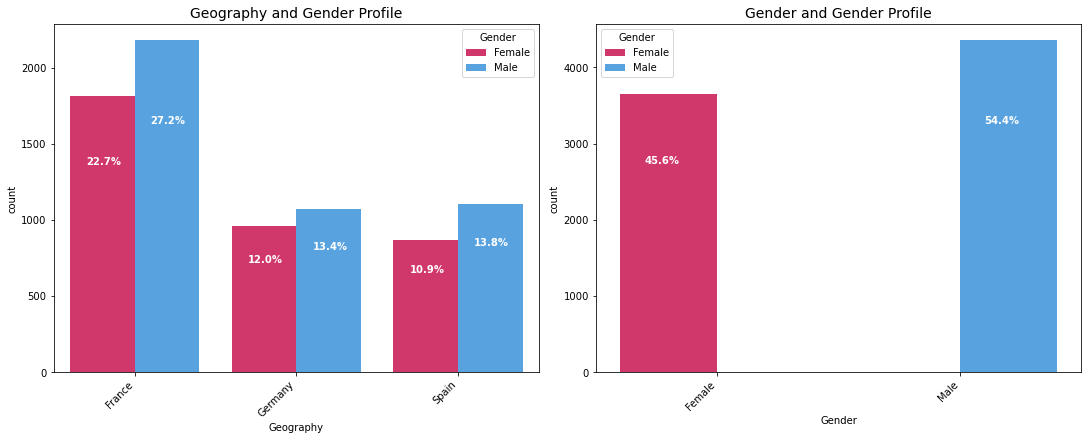

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


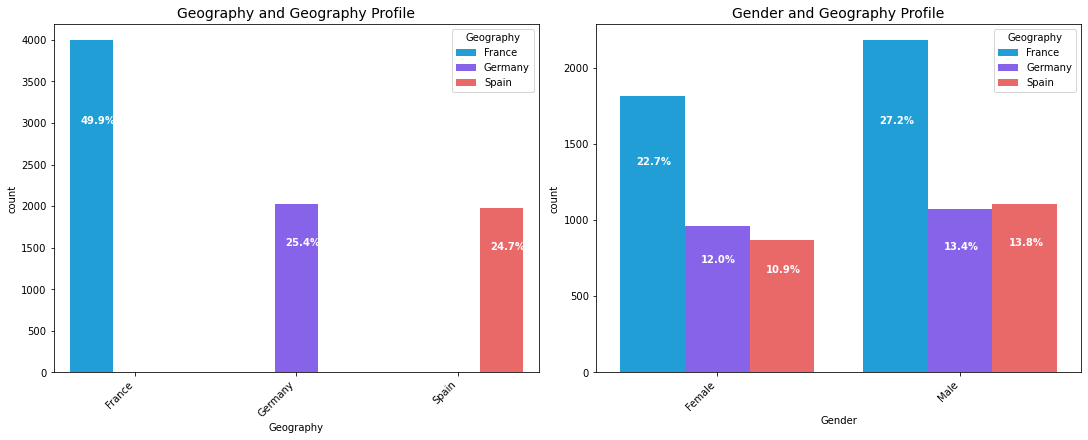

In [12]:
'''
Description:
Displays a grid catplots

Input:
A list of column names
'''
def DisplayCountPlotGrid(col_names, hue_name, color_palette, df):
    col_index = 0
    for r in range(0, int(len(col_names)), 3):
        fig, axs = plt.subplots(
            nrows=1,                                                                # Number of rows of the grid
            ncols=2,                                                                # Number of columns of the grid.
            figsize=(15,6),
            constrained_layout=True)

        for index in range(0, 2):
            if col_index < int(len(col_names)):
                column_name = col_names[col_index]
                ax = axs.flat[index]
                ax = sns.countplot(
                    data    = df,
                    x       = df[column_name],
                    palette = color_palette,
                    hue     = hue_name,
                    ax      = ax)
                ax.set_xlabel(column_name)                                           
                ax.set_title(column_name + ' and '+ hue_name +' Profile', fontsize=14)
                
                total = 0
                for p in ax.patches:
                    if p.get_height() > 0:
                        total += p.get_height()

                for p in ax.patches:
                    percentage = str(((p.get_height() / total) * 100).round(1))+ '%'
                    txt_x = p.get_x() + p.get_width()/4
                    txt_y = p.get_height() - p.get_height()/4
                    ax.text(txt_x,txt_y, percentage, color="white", weight="bold")
                     
                if int(len(ax.get_xticklabels())) > 14: 
                    ax.set_xticklabels([], rotation=45, ha='right')
                else:
                    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
            
            col_index += 1
            
            
catgry_col_names = x_train.select_dtypes(include=['category']).columns.tolist()
print(catgry_col_names)
DisplayCountPlotGrid(
    col_names     = catgry_col_names,
    hue_name      = "Gender",
    color_palette = gender_color_palette,
    df            = x_train)
DisplayCountPlotGrid(
    col_names     = catgry_col_names,
    hue_name      = "Geography",
    color_palette = default_color_palette,
    df            = x_train)